## Lie-Equivariant Quantum Graph Neural Network (Lie-EQGNN)

<img src="figures/Lie-EQGNN-Intro.webp" width=65% style="margin-left:auto; margin-right:auto">

In this notebook, we will walk you through an interesting application for hybrid quantum-classical machine learning. Specifically, we will be covering the architecture from the "[Lie-Equivariant Quantum Graph Neural Network (Lie-EQGNN)](https://arxiv.org/abs/2411.15315)"[1] paper. There is substantial evidence showing that QML models can suffer from poor trainability and generalization [2,3,4], and a well-known phenomenon that illustrates this is the concentration of measure, also known in the community as barren plateaus. Essentially, high-dimensional functions tend to have their measures concentrated around their mean [5]. This results in a flatter landscape, with gradients going close to zero, making it challenging to locate minima. For QML, this is especially true, since our models generally work in exponentially large Hilbert spaces compared to classical neural networks, for instance. As a consequence, efficiently designing new parameterized circuit architectures is crucial. In this tutorial, we explore a hybrid and symmetry-preserving architecture for an important task in particle physics known as jet tagging. By preserving symmetries, we potentially gain many benefits, like reduced sample and model complexity, and improved generalization bounds - due to an effectively reduced hypothesis space.

Below, we begin by importing all the necessary packages, and notice that, for Qibo, we'll be using the PyTorch backend for this tutorial.

In [17]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy.sparse import coo_matrix

from qibo.symbols import Z, I
from qibo.hamiltonians import SymbolicHamiltonian
from qiboml.models.encoding import PhaseEncoding
from qibo import Circuit, gates, hamiltonians
from qiboml.models.decoding import QuantumDecoding
from qiboml.interfaces.pytorch import QuantumModel
from qibo import set_backend

from qiboedu.scripts.lie_eqgnn_utils import *
from qiboedu.scripts.plotscripts import plot_loss, plot_accuracies
from qiboedu.scripts.lie_eqgnn_train import *

set_backend("qiboml",platform="pytorch")

[Qibo 0.2.18|INFO|2025-06-23 13:53:31]: Using qiboml (pytorch) backend on cuda:0


# 1. Dataset

In this work, we consider the task of determining whether a given particle jet originated from a quark or a gluon (this is known as jet-tagging). For illustration we use the high energy physics dataset *Pythia8 Quark and Gluon Jets for Energy Flow* (Patrick T. Komiske et al, 2019)[7], which contains two million jets split equally into one million quark jets and one million gluon jets. These jets resulted from LHC collisions with total center of mass energy $\sqrt{s} = 14$ TeV and were selected to have transverse momenta $p_T^{jet}$ between $500$ to $550$ GeV and rapidities $|y^{jet}| < 1.7$. For our analysis, we randomly picked $N = 12500$ jets and used the first $10000$ for training, the next $1250$ for validation, and the last $1250$ for testing. These sets happened to contain $4982$, $658$, and $583$ quark jets, respectively.

<img src="figures/particle_cloud_mpgan.png" width=65% style="margin-left:auto; margin-right:auto">

*(Figure: the coordinate system (left) used to represent components of the particle momentum $\vec{p}$. Schematic representation of a gluon jet (middle) and a quark jet (right). The jet constituents (solid lines)  are collimated around the jet axis. [Figure adapted from Fig.~1 in (Raghav Kansal et al, 2021).])*


For our purposes, we consider the jet dataset to be constituted of point-clouds, where each jet is represented as a graph $\mathcal{G} = \{\mathcal{V,E}\}$, i.e., a set of nodes and edges, respectively. (This is the natural data structure used by Graph Neural Networks.) In our case, each node has the transverse momentum $p_T$, pseudorapidity $\eta$, azimuthal angle $\phi$ (and other scalar-like quantities like particle ID, particle mass, etc.) of the respective constituent particle in the jet (see the Figure above). Generally, the number of features is always constant, but the number of nodes in each jet may vary. For our analysis we used jets with at least 10 particles.

In [18]:
# to begin loading the jets, we will need some auxiliary functions to handle the graphical format.
# Feel free to just run this part and skip to the next section, where the model is defined.

def get_adj_matrix(n_nodes, batch_size, edge_mask):

    """
        Constructs a batched edge list (adjacency list) from a binary edge mask
        for use in graph neural networks.
    
        Each sample in the batch corresponds to a graph. The edge mask is a 
        binary matrix indicating which node pairs are connected in each graph.
    
        Args:
            n_nodes (int): Number of nodes per graph.
            batch_size (int): Number of graphs in the batch.
            edge_mask (np.ndarray): A batch of 2D binary matrices of shape 
                (batch_size, n_nodes, n_nodes), where edge_mask[b][i][j] = 1 
                if there is an edge from node i to node j in the b-th graph.
    
        Returns:
            list[torch.LongTensor]: A pair of tensors [rows, cols] representing 
            the edges of the batched graph. Each tensor contains node indices 
            and has the correct structure for use in (Quantum) Graph Neural Networks.
    """
    
    rows, cols = [], []
    for batch_idx in range(batch_size):
        nn = batch_idx*n_nodes
        x = coo_matrix(edge_mask[batch_idx])
        rows.append(nn + x.row)
        cols.append(nn + x.col)
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)
    edges = [torch.LongTensor(rows), torch.LongTensor(cols)]
    
    return edges

def collate_fn(data):

    """
    Custom collate function for batching jet graph data.

    This function takes a list of individual jet samples and batches them 
    into a format suitable for model input. It also constructs the batched 
    edge index list using the `get_adj_matrix` function.

    Args:
        data (list): A list of tuples, where each tuple contains 
            (label, p4s, nodes, atom_mask, edge_mask).

    Returns:
        list[torch.Tensor, ...]: A list of batched tensors in the order:
            [labels, p4s, nodes, atom_mask, edge_mask, edges], where edges 
            is a list of LongTensors [rows, cols] representing the adjacency 
            of the batched graphs.
    """
        
    data = list(zip(*data)) # label p4s nodes atom_mask
    data = [torch.stack(item) for item in data]
    batch_size, n_nodes, _ = data[1].size()
    atom_mask = data[-1]
    edge_mask = data[-2]
    edges = get_adj_matrix(n_nodes, batch_size, edge_mask)
    return data + [edges]


def load_jets(p4s, nodes, labels, atom_mask, edge_mask, edges, batch_size, train_ratio, val_ratio, test_ratio):

    """
        Splits the full jet dataset into training, validation, and test sets,
        and returns corresponding PyTorch DataLoaders.
    
        Each sample contains jet features and structure information for graph 
        neural network training. The dataloaders apply batching and adjacency 
        computation via a custom `collate_fn`.
    
        Args:
            p4s (Tensor): 4-momentum features per node (jets), shape [N, n_nodes, 4].
            nodes (Tensor): Node-level features (ie: 4-momenta + particle scalars), shape [N, n_nodes, ...].
            labels (Tensor): Class labels (e.g., quark or gluon), shape [N].
            atom_mask (Tensor): Mask to indicate valid nodes per jet, shape [N, n_nodes].
            edge_mask (Tensor): Binary adjacency mask per sample, shape [N, n_nodes, n_nodes].
            edges (Any): Unused placeholder, included for interface consistency.
            batch_size (int): Number of samples per batch.
            train_ratio (float): Proportion of data used for training.
            val_ratio (float): Proportion of data used for validation.
            test_ratio (float): Proportion of data used for testing.
    
        Returns:
            dict[str, DataLoader]: Dictionary of DataLoaders with keys 
                'train', 'val', and 'test', each yielding batches of data 
                ready for input into a GNN model.
    """
    # Create a TensorDataset
    dataset_all = TensorDataset(labels, p4s, nodes, atom_mask, edge_mask)
    
    # Calculate the lengths for each split
    total_size = len(dataset_all)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size  # Ensure all data is used
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset_all, [train_size, val_size, test_size])
    
    # Create a dictionary to hold the datasets
    datasets = {
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset
    }
    
    dataloaders = {split: DataLoader(dataset,
                                     batch_size=batch_size,
                                     pin_memory=False,
                                     collate_fn = collate_fn,
                                     drop_last=True if (split == 'train') else False,
                                     num_workers=0)
                        for split, dataset in datasets.items()}

    return dataloaders

## Let's load the jet tagging dataset

In [19]:
p4s = torch.load('../data/p4s.pt')
nodes = torch.load('../data/nodes.pt')
labels = torch.load('../data/labels.pt')
atom_mask = torch.load('../data/atom_mask.pt')
edge_mask = torch.from_numpy(np.load('../data/edge_mask.npy'))
edges = torch.from_numpy(np.load('../data/edges.npy'))

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataloaders = load_jets(p4s, nodes, labels, atom_mask, edge_mask, edges, 16, train_ratio, val_ratio, test_ratio)

### Variables for jet tagging:

In [20]:
print(f"""p4s: \t{p4s.shape},
nodes: \t{nodes.shape},
labels: \t{labels.shape},
atom_mask: \t{atom_mask.shape}, 
edge_mask: \t{edge_mask.shape},
edges: \t{edges.shape}""")

p4s: 	torch.Size([12500, 3, 4]),
nodes: 	torch.Size([12500, 3, 1]),
labels: 	torch.Size([12500]),
atom_mask: 	torch.Size([12500, 3]), 
edge_mask: 	torch.Size([12500, 3, 3]),
edges: 	torch.Size([2, 75000])


p4s:       4-momentum tensor of particles in each jet sample with shape [n_samples, n_particles, 4] 
            
nodes:     Additional features per particle (e.g., PID or learned embedding), shape [n_samples, n_particles, 1]

labels:    Jet-level labels for classification (e.g., quark vs gluon), shape [n_samples]

atom_mask: Binary mask indicating which particles are valid (not padding), shape [n_samples, n_particles]

edge_mask: Binary mask indicating which particle-pair interactions (edges) are valid, shape [n_samples, n_particles, n_particles]

edges:     Edge list for message-passing (graph connectivity), shape [2, n_edges], with each column (src, dst) across all samples


# 2. Quantum and Classical Graph Neural Networks

Graph Neural Networks (GNNs) are a class of neural networks designed to operate on graph-structured data. Unlike traditional neural networks that work on Euclidean data such as images or sequences, GNNs are capable of capturing the dependencies and relationships between nodes in a graph. The fundamental idea behind is to iteratively update the representation of each node by aggregating information from its neighbors, thereby enabling the network to learn both local and global graph structures.

Given the inherent graph structure of our dataset, which captures the complex interactions and relationships between particles, it is natural to employ graph neural networks (GNNs) for the task of tagging quarks versus gluons. We start our approach with a classical, symmetry-preserving GNN to establish a foundational understanding and then discuss how we can extend this setting to introduce quantum computing.

To start, let $ \mathcal{G} = (\mathcal{V}, \mathcal{E}) $ be a graph where $ \mathcal{V} $ is its corresponding, set of nodes and $ \mathcal{E} $ is its set of edges. Each node $ v \in \mathcal{V} $ has an initial feature vector $ \mathbf{h}_v^{(0)} $, which is updated throughout multiple layers of the GNN. At each layer $ l $, the feature vector of the node $ v $ is updated by aggregating the neighboring feature vectors $ \mathcal{N}(v) $, and then combining them with its own features. The final node representations can be used for various downstream tasks such as node classification, link prediction, or graph classification. The latter is our case.

# A primer to invariance-equivariance constraint

As a simple way to illustrate how it is possible to bake a group-equivariance constraint into a GNN, consider a dataset of graphs in which its nodes have cartesian coordinates as inputs features, and let $SO(2)$ - the group of $2D$ rotations - be their underlying symmetry group. Since the Euclidean norm is invariant to rotations, any node-updating function of the form:

\begin{equation}
    x_{i}^{l+1} = x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)} (x_{i}^{l} - x_{j}^{l})\;\phi_x (m_{ij}^{l})
\end{equation}

is naturally equivariant, where $\phi_x$ can be a classical neural network, and $m_{ij}^{l}$ is the edge message between nodes $i$ and $j$ in layer $l$. To see why equivariance holds in this case, we just need to see that, for any arbitrary rotation matrix $R$:

\begin{align}
    R x_{i}^{l+1} &= R x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)} (R x_{i}^{l} - R x_{j}^{l})\;\phi_x (m_{ij}^{l})\\
    &= R x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)} R (x_{i}^{l} - x_{j}^{l})\;\phi_x (m_{ij}^{l})\\
    &= R(x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)}(x_{i}^{l} - x_{j}^{l})\;\phi_x (m_{ij}^{l}) )
\end{align}

This means that applying a rotation from the inside, directly transforming the data points (nodes), and then updating their coordinate, is equivalent to applying a rotation from the outside, that is, first updating their coordinate, and then acting with the group. The equation above implies that $m_{ij}^{l}$ also needs to be invariant, which can be achieved by having its inputs also being invariant measures,  like the euclidean norm given above and the standard dot-product, since $\langle x, y\rangle = \langle Rx, Ry\rangle$; it is easy to check, then, that equivariance breaks on the contrary. In the next section, we show how using a very similar formulation allows us to preserve the Lorentz group, a key symmetry in all of relativistic quantum field theory and inherent to almost all tasks involving high-energy particle scattering experiments, like we do in the Large Hadron Collider (LHC), at CERN.

# 3. LorentzNet
The first Lorentz-group preserving architecture we shall see is a very well known one in the particle physics community, called **LorentzNet** ([arXiv:2201.08187](https://arxiv.org/abs/2201.08187))[6]. This is going to be a classical model, and through the course of this tutorial we'll understand where to fit in quantum computing, which will be the heart of our approach. Before any quantum, let's see what this classical model is doing first. The whole idea is to preserve the group actions by using universally-approximating Lorentz-equivariant polynomials, which will be responsible for the message passing scheme, and also updating the particle scalar and four-momentum latent representations. We can illustrate it as follows:

<center>
<img src="figures/LorentzNet.png" width="65%" style="margin-left:auto; margin-right:auto">
</center>

*(Figure: Schematic representation of the LorentzNet architecture.)*


From the beginning, the **input** here consists of a concatenation of four-momentum vectors (called just particle coordinates from now on) and additional scalar features, like color, charge, flavor, etc. The combined feature vector for each particle (node) is:

$$
f_i = v_i \oplus s_i,
$$

where $\oplus$ denotes concatenation. Next, we turn to the core building block of this architecture:

**Lorentz Group Equivariant Block (LGEB)**

This is where the node and edge features are updated while preserving the Lorentz equivariance. The key components are symmetry-preserving functions for updating the coordinate, scalar and edge message features. Overall, we could summarize the architecture as follows:

1. **Invariant Edge Message Function $\phi_e$**:
   - Computes messages passed between particles.
   - Captures pairwise interactions and relativistic geometrical relationships.
   - Depends on Lorentz-invariant scalars, hence the edge message is invariant.
     
2. **Equivariant Coordinate Update Function $\phi_x$**:
   - Updates the coordinate embeddings of particles.
   - Incorporates attention mechanisms respecting Minkowski spacetime.
   - Ensures Lorentz-equivariance in its definition.
     
3. **Invariant Scalar Feature Update Function $\phi_h$**:
   - Updates scalar features of particles.
   - Aggregates information from neighboring particles.
   - Again, depends on Lorentz-invariant scalar features, so it is also invariant.
     
These functions are modeled using neural networks capable of approximating continuous functions. Here, in each $\phi$, we are going to introduce quantum neural networks to add more expressivity to the mix. Since QNNs are also universal approximators, we are good to go.

## 3.1. Detailed Formulation

1. **Edge Message Computation $\phi_e$**:

   For particles $i$ and $j$ at layer $l$, the **edge message** $m_{ij}^{l}$ is computed as:

   $$
   m_{ij}^{l} = \phi_e \left( h_i^{l}, h_j^{l}, \psi\left( \| x_i^{l} - x_j^{l} \|^2 \right), \psi\left( \langle x_i^{l}, x_j^{l} \rangle \right) \right),
   $$

   where:

   - $h_i^{l}$ and $h_j^{l}$ are the scalar features of particles $i$ and $j$ at layer $l$.
   - $x_i^{l}$ and $x_j^{l}$ are the coordinate embeddings (four-vectors) at layer $l$.
   - $\| x_i^{l} - x_j^{l} \|^2$ is the squared Minkowski **distance** between particles $i$ and $j$.
   - $\langle x_i^{l}, x_j^{l} \rangle$ is the Minkowski **inner product** (Lorentz dot product).
   - $\psi(\cdot)$ is a normalization function to help stabilize the gradients due to large numbers, and is defined in the paper as:

     $$
     \psi(a) = \operatorname{sgn}(a) \cdot \log\left( |a| + 1 \right),
     $$

     with $\operatorname{sgn}(a)$ being the sign function.

2. **Coordinate Embedding Update $\phi_x$**:

   The **coordinate embeddings** of particles are updated by a neighborhood-dependent equivariant function:

   $$
   x_i^{l+1} = x_i^{l} + c \sum_{j \in \mathcal{N}(i)} \phi_x ( m_{ij}^{l}) \cdot x_j^{l},
   $$

   where:

   - $\mathcal{N}(i)$ denotes the **neighborhood** of particle $i$, i.e., particles connected to $i$ in the graph.
   - $c$ is a scaling constant controlling the update magnitude.
   - $\phi_x ( m_{ij}^{l})$ computes an **attention weight** based on the edge message $m_{ij}^{l}$.


3. **Scalar Feature Update $\phi_h$**:

   Finally, the **scalar features** are updated as:

   $$
   h_i^{l+1} = h_i^{l} + \phi_h \left( h_i^{l}, \sum_{j \in \mathcal{N}(i)} w_{ij}^{l} m_{ij}^{l} \right),
   $$

   where:

   - $w_{ij}^{l}$ is an **edge significance weight** calculated by:

     $$
     w_{ij}^{l} = \phi_m \left( m_{ij}^{l} \right) \in [0, 1],
     $$

     with $\phi_m$ being a neural network outputting values in the range [0, 1].

   - $\phi_h$ aggregates information from neighboring particles to update $h_i^{l}$.

The purpose of $w_{ij}^{l}$ is to learn the importance of the edge connecting particles $i$ and $j$, and $\phi_h$ integrates these weighted messages to refine the scalar features, so our model can potentially learn more complex interactions.

A noteworthy aspect of LorentzNet is its approach to handling outputs: although both **coordinate embeddings** $x_i^{l}$ and **scalar features** $h_i^{l}$ are updated through the layers, the final output only uses the **scalar features** $h_i^{L}$ from the last layer $L$. This strategy reduces redundancy and computational overhead because the edge messages $m_{ij}^{l}$ already incorporate information from both $x_i^{l}$ and $x_j^{l}$.
      
**Implementation Details**

To ensure fidelity with the original LorentzNet architecture and leverage existing optimizations, we utilize the official implementation provided by the authors:

- **Repository**: [LorentzNet-release](https://github.com/sdogsq/LorentzNet-release/tree/main)

## Let's define our parameterized circuits.

In order to measure multiple observables and perform gradient descent afterwards, the first thing that we'll need is to define a CustomDecoder. Before anything else, let's also define an auxiliary function to create a list of observables of the form

\begin{align*}
\text{Observables }=[\hat{\sigma}_z &\otimes \mathbb{I} \otimes \mathbb{I} \otimes \cdots \otimes \mathbb{I},\\
\mathbb{I} &\otimes \hat{\sigma}_z \otimes \mathbb{I} \otimes \cdots \otimes \mathbb{I},\\
\mathbb{I} &\otimes \mathbb{I} \otimes \hat{\sigma}_z \otimes \cdots \otimes \mathbb{I},\\
\mathbb{I} &\otimes \mathbb{I} \otimes \mathbb{I} \otimes \cdots \otimes \hat{\sigma}_z]
\end{align*}

In [21]:
def create_hamiltonians(n_qubits):
    """
        Creates a list of local measurement Hamiltonians for each qubit,
        where each Hamiltonian corresponds to a Z observable acting on a
        specific qubit and identity elsewhere.
    
        These symbolic Hamiltonians can be used to compute ⟨Z_i⟩ expectation 
        values for each qubit independently in the readout.
    
        Args:
            n_qubits (int): Number of qubits in the circuit.
    
        Returns:
            list[SymbolicHamiltonian]: A list of length `n_qubits`, where 
            each element is a `SymbolicHamiltonian` representing a Pauli-Z 
            measurement on qubit i.
    
        Example:
            >>> hs = create_hamiltonians(3)
            >>> # hs[0] corresponds to Z ⊗ I ⊗ I
            >>> # hs[1] corresponds to I ⊗ Z ⊗ I
            >>> # hs[2] corresponds to I ⊗ I ⊗ Z
    """
    
    measurements = []
    for i in range(n_qubits):
        hamiltonians = [I(i) for i in range(n_qubits)]
        hamiltonians[i] = Z(i)
    
        H = 1
        for term in hamiltonians:
            H *= term
            
        H = SymbolicHamiltonian(H)
        measurements.append(H)
    
    return measurements

In [22]:
class CustomDecoderMultipleZ(QuantumDecoding):

    """
        A custom quantum decoding module that measures the expectation values 
        of Z-observables (or similar Hamiltonians) on each qubit of the final 
        quantum state.

        
        Attributes:
            nqubits (int): Number of qubits to be measured from the quantum circuit.
            hamilts (list): List of symbolic Hamiltonians from Qibo 
                            used to define measurements on each qubit.
        
        Methods:
            __call__(x: Circuit):
                Runs the given circuit and returns a tensor of expectation 
                values, one per qubit.
        
            output_shape:
                Returns the shape of the output tensor, which is `(nqubits,)`.
        
        Example:
            decoder = CustomDecoderMultipleZ(nqubits=4)
            circuit = build_some_quantum_circuit()
            output = decoder(circuit)  # shape: (4,), each entry is ⟨Z_i⟩
    """
    
    def __init__(self, nqubits: int):
        super().__init__(nqubits)
        # build the observables using qibo's SymbolicHamiltonian
        self.nqubits = nqubits
        self.hamilts = create_hamiltonians(nqubits)

    def __call__(self, x: Circuit):
        # execute the circuit and collect the final state
        state = super().__call__(x).state()

        # collect expectation values (each one must be a torch Tensor!)
        expvals = [self.hamilts[i].expectation(state)        # scalar tensor
                   for i in range(self.nqubits)]

        # stack them without breaking the gradient graph
        return torch.stack(expvals)      # shape (nqubits,)
        
    # specify the shape of the output
    @property
    def output_shape(self) -> tuple[int]:
        return (self.nqubits)

In [23]:

def create_quantum_net(n_qubits, nlayers):

    """
        Constructs the parameterized quantum circuit ansatz to use in 
        our hybrid EQGNN.
    
        This quantum network is composed of three main components:
        - An input encoder (PhaseEncoding),
        - A simple variational circuit (with trainable RY and RZ rotations and entangling CNOTs),
        - The custom decoding layer we defined above in CustomDecoderMultipleZ.
    
        Args:
            n_qubits (int): Number of qubits (nodes in the quantum circuit).
            nlayers (int): Number of repeated variational layers applied after initial Hadamards.
    
        Returns:
            tuple:
                - encoding (PhaseEncoding): Module for embedding classical input into quantum state.
                - circuit (Circuit): TorchQuantum Circuit object with trainable parameters.
                - decoding (CustomDecoderMultipleZ): Module for decoding the quantum state back to classical readout.
        
        Notes:
            - The variational layers use RY and RZ gates with randomly initialized angles that are trainable.
            - CNOT gates introduce entanglement between neighboring qubits, wrapping around at the edges.
            - The design allows the circuit to be used as a building block in a hybrid GNN-quantum model.
    """
    
    qubits = list(range(n_qubits))
    
    # define the encoding
    encoding = PhaseEncoding(nqubits=n_qubits)

    # build the computation circuit
    circuit = Circuit(n_qubits)

    decoding = CustomDecoderMultipleZ(n_qubits)
    
    circuit.add(gates.H(q) for q in qubits)
    for layer in range(nlayers):
        for q in qubits:
            circuit.add(gates.RY(q, theta=torch.randn(1) * np.pi, trainable=True)) # random.random()
            circuit.add(gates.RZ(q, theta=torch.randn(1) * np.pi, trainable=True))

        if n_qubits > 1:
            for i, q in enumerate(qubits[:-2]):
                circuit.add(gates.CNOT(q0=q, q1=qubits[i + 1]))
            circuit.add(gates.CNOT(q0=qubits[-1], q1=qubits[0]))

    return encoding, circuit, decoding

## Architecture

In [24]:
"""
    Quantum Lie-Equivariant Group Block (QLieGEB).
    
        - This is the key component of the model, where coordinate and scalar representations
        are accordingly updated, respecting the continuous group-equivariance constraint. All
        the aforementioned updating functions (ie: phi_m, phi_x, phi_h, etc) will be defined here.
"""
class QLieGEB(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_node_attr=0,
                 dropout = 0., c_weight=1.0, last_layer=False, A=None, include_x=False, 
                 model_type='classical', nlayers_qnn = 4, device='cpu'):
        
        super(QLieGEB, self).__init__()
        self.c_weight = c_weight
        self.model_type = model_type
        n_edge_attr = 2 if not include_x else 10 # dims for Minkowski norm & inner product
        
        self.device = device
        
        self.include_x = include_x

        """
            phi_e: input size: n_qubits -> output size: n_qubits
            n_hidden has to be equal to n_input (n_input * 2 + n_edge_attr),
            but this is just considering that this is a simple working example.
        """

        
        self.n_hidden = n_input * 2 + n_edge_attr
        
        if model_type in ['phi_e', 'quantum']:

            n_qubits=n_input * 2 + n_edge_attr

            self.n_output_e = self.n_hidden
            
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn)
            q_circuit_e = QuantumModel([encoding, circuit], decoding)

            self.phi_e = nn.Sequential(q_circuit_e,
                                      nn.Linear(n_qubits, self.n_hidden),
                                      nn.ReLU())
            self.BatchNorm1d_e = nn.BatchNorm1d(self.n_hidden)
        else:
            self.phi_e = nn.Sequential(
                        nn.Linear(n_input * 2 + n_edge_attr, self.n_hidden, bias=False),
                        nn.BatchNorm1d(self.n_hidden),
                        nn.ReLU(),
                        nn.Linear(self.n_hidden, self.n_hidden),
                        nn.ReLU()).float()
            

        if model_type in ['phi_h', 'quantum']:
            
            n_qubits=self.n_hidden
            
            self.n_output_h = n_output
            
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn)
            q_circuit_h = QuantumModel([encoding, circuit], decoding)

            self.phi_h = nn.Sequential(nn.Linear(self.n_hidden + n_input + n_node_attr, self.n_hidden, bias=False),
                                       # nn.BatchNorm1d(n_hidden),
                                       nn.ReLU(),
                                       q_circuit_h,
                                       nn.Linear(n_qubits, n_output))

            
            self.BatchNorm1d_h = nn.BatchNorm1d(4)
            
        else:
            self.phi_h = nn.Sequential(
                nn.Linear(self.n_hidden + n_input + n_node_attr, self.n_hidden),
                nn.BatchNorm1d(self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, n_output))

        

        if model_type in ['phi_x', 'quantum']:
            down_projection = nn.Linear(self.n_hidden, 1, bias=False)
            torch.nn.init.xavier_uniform_(down_projection.weight, gain=0.001)

            n_qubits=self.n_hidden
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn)
            q_circuit_x = QuantumModel([encoding, circuit], decoding)

            self.phi_x = nn.Sequential(q_circuit_x,
                                       down_projection)
                        
        else:
            layer = nn.Linear(self.n_hidden, 1, bias=False)
            torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
            self.phi_x = nn.Sequential(
                nn.Linear(self.n_hidden, self.n_hidden),
                nn.ReLU(),
                layer)

        
        if model_type in ['phi_m', 'quantum']:

            n_qubits=1
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn,)
            q_circuit_m = QuantumModel([encoding, circuit], decoding)

            self.phi_m = nn.Sequential(nn.Linear(self.n_hidden, 1),
                                       nn.ReLU(),
                                       q_circuit_m)
        else:
            self.phi_m = nn.Sequential(
                nn.Linear(self.n_hidden, 1),
                nn.Sigmoid())    

        
        self.last_layer = last_layer
        if last_layer:
            del self.phi_x

        self.A = A
        self.norm_fn = normA_fn(A) if A is not None else normsq4
        self.dot_fn = dotA_fn(A) if A is not None else dotsq4

    def m_model(self, hi, hj, norms, dots):

        """
        Computes Lorentz-invariant edge messages for the graph neural network.
    
        This method builds the input to the message function `phi_m` by concatenating:
        - Node scalar features `hi` and `hj` (associated with source and target nodes),
        - The Minkowski norm between their positions,
        - The Minkowski dot product.
    
        Since all these quantities are Lorentz-invariant, the resulting message is also invariant under Lorentz transformations.
    
        If `self.model_type` is `"phi_e"` or `"quantum"`, the message is processed through a secondary message model `phi_e`
        in a per-edge fashion, followed by batch normalization. This can represent hybrid models (e.g., quantum-classical).
    
        Parameters
        ----------
        hi : Tensor
            Node features from source nodes.
        hj : Tensor
            Node features from target nodes.
        norms : Tensor
            Minkowski norms (||x_i - x_j||) for each edge.
        dots : Tensor
            Minkowski dot product tensor for all combinations of nodes
            i and j in the jet.
    
        Returns
        -------
        out : Tensor
            Final message tensor for each edge after applying the mask `phi_m`.
        """
    
        out = torch.cat([hi, hj, norms, dots], dim=1)

        if self.model_type in ["phi_e", "quantum"]:
            out2 = torch.empty(0, self.n_output_e).to(self.device)
            for x in out:
                out2 = torch.cat((out2, self.phi_e(x).unsqueeze(0).to(self.device)) )
    
            out = self.BatchNorm1d_e(out2)
        
        w = self.phi_m(out)
        out = out * w
        return out

    def m_model_extended(self, hi, hj, norms, dots, xi, xj):

        """

        Very similar to m_model, but it also includes information from the coordinate
        space. This was originally proposed by the authors to save computational resources.
        
        Parameters
        ----------
        hi : Tensor
            Node features from source nodes.
        hj : Tensor
            Node features from target nodes.
        norms : Tensor
            Minkowski norms (||x_i - x_j||) for each edge.
        dots : Tensor
            Minkowski dot product tensor for all combinations of nodes
            i and j in the jet.
        xi: Tensor
            Coordinate tensor of source nodes.
        xj: Tensor
            Coordinate tensor of target nodes.
    
        Returns
        -------
        out : Tensor
            Final message tensor for each edge after applying the mask `phi_m`.
        """
        
        out = torch.cat([hi, hj, norms, dots, xi, xj], dim=1)
        out = self.phi_e(out).squeeze(0)
        w = self.phi_m(out)
        out = out * w
        return out

    def h_model(self, h, edges, m, node_attr):
        """
        Computes Lorentz-invariant scalar latent representation.
    
        This method updates the latent representation using also Lorentz-invariant 
        features. 
    
        Since we are adding support for batch predictions, currently, if `self.model_type` 
        is `"phi_e"` or `"quantum"`, each scalar representation is processed individually 
        and then concatenated to the batch before going to the batch normalization. 
        
        Parameters
        ----------
        h: Tensor
            scalar representations to be updated in the batch.
        edges : Tensor
            Edge index tensor defined in the beginning.
        m : Tensor
            Message tensor, computed in m_model.
        node_attr : Tensor
            This is the node attribute tensor.
    
        Returns
        -------
        out : Tensor
            Final scalar tensor for each particle after applying `phi_h`.
        """
        i, j = edges
        agg = unsorted_segment_sum(m, i, num_segments=h.size(0))
        agg = torch.cat([h, agg, node_attr], dim=1)


        if self.model_type in ["phi_h", "quantum"]:
            out = torch.empty(0, self.n_output_h).to(self.device)
            for x in agg:
                out = torch.cat((out, self.phi_h(x).unsqueeze(0).to(self.device)) )
            out = self.BatchNorm1d_h(out)
            out = h + out
        else:
            out = h + self.phi_h(agg)
            
        return out

    def x_model(self, x, edges, x_diff, m):
        """
        Lorentz-equivariant coordinate update function, as detailed above.

        Parameters
        ----------
        x: Tensor
            Coordinate representations to be updated in the batch.
        edges : Tensor
            Edge index tensor.
        m : Tensor
            Message tensor, computed in m_model.
        x_diff : Tensor
            This tensor contains the Minkowski distances between each
            pair of particles in four-momentum space.
    
        Returns
        -------
        x : Tensor
            Final updated coordinate tensor for each particle.
        """
        i, j = edges
        
        # trans = x_diff * out
        trans = x_diff * self.phi_x(m)
        # From https://github.com/vgsatorras/egnn
        # This is never activated but just in case it explosed it may save the train
        trans = torch.clamp(trans, min=-100, max=100)
        agg = unsorted_segment_mean(trans, i, num_segments=x.size(0))
        x = x + agg * self.c_weight
        return x

    def minkowski_feats(self, edges, x):

        """
        Compute Minkowski-inspired edge features from node coordinates.

        Parameters
        ----------
        edges : tuple of Tensors (i, j)
            A tuple containing index tensors for source (`i`) and target (`j`) nodes.
        x : Tensor
            Tensor of node coordinates, where each row is a feature vector 
            (e.g., four-momentum).
    
        Returns
        -------
        norms : Tensor
            Minkowski norm (or modified norm) of pairwise differences, shape [num_edges, 1].
        dots : Tensor
            Minkowski inner product between node coordinate pairs, shape [num_edges, 1].
        x_diff : Tensor
            Coordinate difference vector x[i] - x[j] for each edge, shape [num_edges, coord_dim].
        """
        
        i, j = edges
        x_diff = x[i] - x[j]
        norms = self.norm_fn(x_diff).unsqueeze(1)
        dots = self.dot_fn(x[i], x[j]).unsqueeze(1)
        norms, dots = psi(norms), psi(dots)
        return norms, dots, x_diff

    def forward(self, h, x, edges, node_attr=None):
        
        """
        Forward pass of the Minkowski GNN layer.
    
        Parameters
        ----------
        h : Tensor
            Node hidden features of shape [num_nodes, hidden_dim].
        x : Tensor
            Node coordinate features (e.g., spacetime or geometric coordinates), 
            shape [num_nodes, coord_dim].
        edges : tuple of Tensors (i, j)
            Edge index tuple identifying source and target node pairs.
        node_attr : Tensor, optional
            Optional node attributes to be passed into the `h_model`,
            shape [num_nodes, attr_dim].
    
        Returns
        -------
        h : Tensor
            Updated node features after message passing, shape [num_nodes, hidden_dim].
        x : Tensor
            Optionally updated coordinate features (if `self.last_layer == False`),
            shape [num_nodes, coord_dim].
        m : Tensor
            Edge messages computed via the message models, shape [num_edges, hidden_dim].
        """
        
        i, j = edges
        norms, dots, x_diff = self.minkowski_feats(edges, x)

        if self.include_x:
            m = self.m_model_extended(h[i], h[j], norms, dots, x[i], x[j])
        else:
            m = self.m_model(h[i], h[j], norms, dots) # [B*N, hidden]
        if not self.last_layer:
            x = self.x_model(x, edges, x_diff, m)
        h = self.h_model(h, edges, m, node_attr)
        return h, x, m

class LieEQGNN(nn.Module):
    r''' Implementation of Lie-Equivariant Quantum Graph Neural Network (Lie-EQGNN).

    Args:
        - `n_scalar` (int): number of input scalars.
        - `n_hidden` (int): dimension of latent space.
        - `n_class`  (int): number of output classes.
        - `n_layers` (int): number of QLieGEB layers.
        - `c_weight` (float): weight c in the x_model.
        - `dropout`  (float): dropout rate.
    '''
    def __init__(self, n_scalar, n_hidden, n_class = 2, n_layers = 6, c_weight = 1e-3, dropout = 0., A=None, include_x=False,
                model_type='classical', nlayers_qnn = 4, device='cpu'):
        
        super(LieEQGNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.embedding = nn.Linear(n_scalar, n_hidden)
        self.QLieGEBs = nn.ModuleList([QLieGEB(self.n_hidden, self.n_hidden, self.n_hidden, 
                                    n_node_attr=n_scalar, dropout=dropout,
                                    c_weight=c_weight, last_layer=(i==n_layers-1), A=A, include_x=include_x,
                                    model_type=model_type, nlayers_qnn = nlayers_qnn, device=device)
                                    for i in range(n_layers)])
        
        self.graph_dec = nn.Sequential(nn.Linear(self.n_hidden, self.n_hidden),
                                       nn.ReLU(),
                                       nn.Dropout(dropout),
                                       nn.Linear(self.n_hidden, n_class)) # classification

    def forward(self, scalars, x, edges, node_mask, edge_mask, n_nodes, show_embeddings=False):
        h = self.embedding(scalars)

        # here, show_embeddings will be used to illustrate how the group-equivariance constraint
        # works in practice. We'll show that Lorentz transformations preserve the scalar latent
        # representations, whereas any other transformation violates this condition.
        if show_embeddings:
            print("Scalar embedding, h, before (first particle): \n", h[0].cpu().detach().numpy())
    
        for i in range(self.n_layers):
            h, x, _ = self.QLieGEBs[i](h, x, edges, node_attr=scalars)

        if show_embeddings:
            print("Scalar embedding, h, after transformation (first particle): \n", h[0].cpu().detach().numpy())
        
        h = h * node_mask
        h = h.view(-1, n_nodes, self.n_hidden)
        h = torch.mean(h, dim=1)
        pred = self.graph_dec(h)
        return pred.squeeze(1)

### Invariance-Equivariance analysis

Let's see if the architecture does in fact preserve the actions from the Lorentz group. Let's start with a default prediction without any symmetry action on the inputs:

In [25]:
# let's get one batch of data (X, Y).
label, p4s, nodes, atom_mask, edge_mask, edges = next(iter(dataloaders['test']))

In [26]:
# here, we are just putting every component into the chosen device, which is GPU for this notebook,
# and also casting to the compatible data types for PyTorch.

dtype = torch.float64
device = 'cuda'

batch_size, n_nodes, _ = p4s.to(device, dtype).size()
atom_positions = p4s.view(batch_size * n_nodes, -1).to(device, dtype)
atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device, dtype)
edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device, dtype)
nodes = nodes.view(batch_size * n_nodes, -1).to(device, dtype)
edges = [a.to(device) for a in edges]
label = label.to(device, dtype).long()

In [27]:
# Finally, we instantiate our model.
# Very important: for running our analysis,
# we'll incorporate PQCs only into phi_x for simplicity.

model = LieEQGNN(n_scalar = 1, n_hidden = 4, n_class = 2,\
                   dropout = 0.2, n_layers = 4,\
                   c_weight = 1e-3, model_type="phi_x", 
                   nlayers_qnn = 3, device=device).to(device, dtype=torch.float64)

In [28]:
pred = model(scalars=nodes, x= atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes, show_embeddings=True)

Scalar embedding, h, before (first particle): 
 [ 0.85502088 -0.16309357 -0.65026248 -0.54300666]
Scalar embedding, h, after transformation (first particle): 
 [-0.27167404  0.4047632  -2.35204291 -2.33705293]


So, we have a prediction where we see the latent representation for the first particle scalar in the first jet. Does taking any random transformation in the four-momentum vectors (i.e.: multiplying by 0.1) preserve our particle's latent representation?

In [29]:
pred = model(scalars=nodes, x= 0.1 * atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes, show_embeddings=True)

Scalar embedding, h, before (first particle): 
 [ 0.85502088 -0.16309357 -0.65026248 -0.54300666]
Scalar embedding, h, after transformation (first particle): 
 [ 0.08720784  0.33043389 -1.85651527 -1.98908419]


The logits for the particle scalar have changed after the transformation, and we have **broken the symmetry**. Now, what about the Lorentz group actions?

In [30]:
pred = model(scalars=nodes, x= (torch.tensor(transformation_matrix(220000000)).to(device) @ atom_positions.to(device, dtype=torch.float64).T).to(device, dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes, show_embeddings=True)

Scalar embedding, h, before (first particle): 
 [ 0.85502088 -0.16309357 -0.65026248 -0.54300666]
Scalar embedding, h, after transformation (first particle): 
 [-0.2716742   0.40476323 -2.35204311 -2.33705303]


The latent representation is **preserved** when applying a Lorentz boost to our jet, which is the correct symmetry.

## 5. Training

Finally, let's train on some data!

In [31]:
N_EPOCHS = 60

# put your model and log path here.
model_path = "../models/LieEQGNN/"
log_path = "../logs/LieEQGNN/"

### set random seed
torch.manual_seed(42)
np.random.seed(42)

### initialize cuda
device = 'cuda'
dtype = torch.float64

model = LieEQGNN(n_scalar = 1, n_hidden = 4, n_class = 2,\
                   dropout = 0.2, n_layers = 1,\
                   c_weight = 1e-3).to(device, dtype)

### print model and dataset information
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Model Size:", pytorch_total_params)
for (split, dataloader) in dataloaders.items():
    print(f" {split} samples: {len(dataloader.dataset)}")

### optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

### lr scheduler
base_scheduler = CosineAnnealingWarmRestarts(optimizer, 4, 2)
lr_scheduler = GradualWarmupScheduler(optimizer, multiplier=1,\
                                            warmup_epoch=5,\
                                            after_scheduler=base_scheduler) ## warmup

### loss function
loss_fn = nn.CrossEntropyLoss()

### initialize logs
res = {'epochs': [], 'lr' : [],\
       'train_time': [], 'val_time': [],  'train_loss': [], 'val_loss': [],\
       'train_acc': [], 'val_acc': [], 'best_val': 0, 'best_epoch': 0}

### training and testing
print("Training...")
train(model, optimizer, lr_scheduler, dataloaders, res, N_EPOCHS, 
      model_path, log_path, loss_fn=loss_fn, device=device, dtype=dtype)

print("Testing...")
test(model, dataloaders, res, model_path, log_path,
     loss_fn=loss_fn, device=device, dtype=dtype)

Model Size: 503
 train samples: 10000
 val samples: 1250
 test samples: 1250
Training...
>> train 	 Epoch 1/60 	 Batch 624/625 	 Loss 0.7537 	 Running Acc 0.500 	 Total Acc 0.500 	 Avg Batch Time 0.0070
Time: train: 4.40 	 Train loss 0.7537 	 Train acc: 0.5003
>> val 	 Loss 0.7165 	 Running Acc 4.095 	 Total Acc 0.518 	 Avg Batch Time 0.0006
New best validation model, saving...
Epoch 0/60 finished.
Train time: 4.40 	 Val time 0.35
Train loss 0.7537 	 Train acc: 0.5003
Val loss: 0.7164 	 Val acc: 0.5176
Best val acc: 0.5176 at epoch 0.
>> train 	 Epoch 2/60 	 Batch 624/625 	 Loss 0.6891 	 Running Acc 0.549 	 Total Acc 0.549 	 Avg Batch Time 0.0070
Time: train: 4.35 	 Train loss 0.6891 	 Train acc: 0.5495
>> val 	 Loss 0.6672 	 Running Acc 4.646 	 Total Acc 0.587 	 Avg Batch Time 0.0005
New best validation model, saving...
Epoch 1/60 finished.
Train time: 4.35 	 Val time 0.28
Train loss 0.6891 	 Train acc: 0.5495
Val loss: 0.6683 	 Val acc: 0.5872
Best val acc: 0.5872 at epoch 1.
>> trai

## Plots

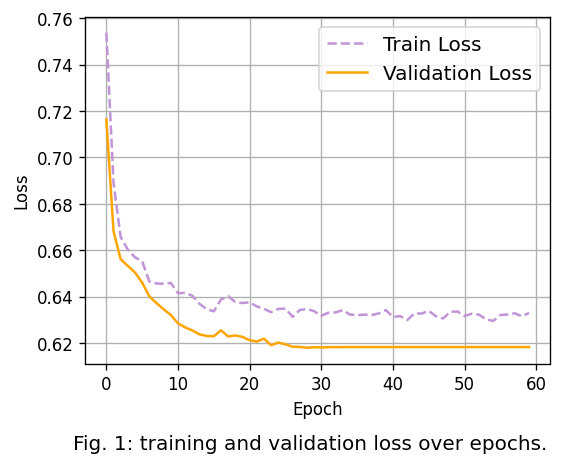

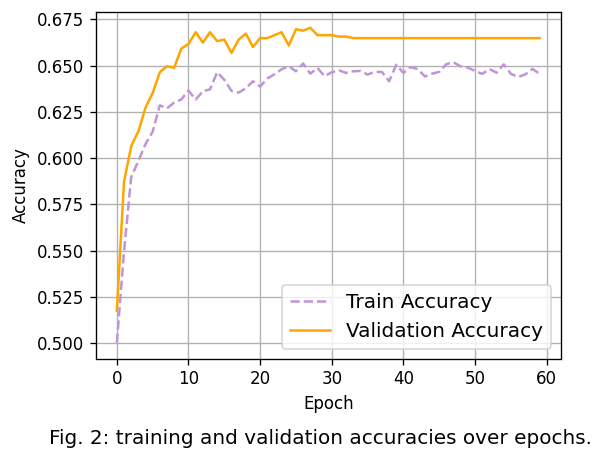

In [32]:
import os
import json
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)

log_path = "../logs/LieEQGNN/test-result.json"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


with open(log_path) as f:

    data = json.load(f)
    epochs = data["epochs"]
    train_loss = data["train_loss"]
    val_loss = data["val_loss"]
    train_acc = data["train_acc"]
    val_acc = data["val_acc"]

    plot_loss(data["epochs"], data["train_loss"], data["val_loss"])
    plot_accuracies(data["epochs"], data["train_acc"], data["val_acc"])

## References

[1] Neto, Jogi Suda, et al. "[Lie-Equivariant Quantum Graph Neural Networks.](https://arxiv.org/abs/2411.15315)" arXiv preprint arXiv:2411.15315 (2024).

[2] Jonas M. Kübler, et al. "[The inductive bias of quantum kernels](https://proceedings.neurips.cc/paper/2021/file/69adc1e107f7f7d035d7baf04342e1ca-Paper.pdf)", 2021.

[3] Jarrod R. McClean, et al. "[Barren plateaus in quantum neural network training landscapes](https://www.nature.com/articles/s41467-018-07090-4)". Nature Communications, 9(1), November 2018.

[4] M. Cerezo, et al. "[Cost function dependent barren plateaus in shallow parametrized quantum circuits](https://www.nature.com/articles/s41467-021-21728-w)". Nature Communications, 12(1), March 2021.

[5] Tüysüz, Cenk, et al. "[Symmetry breaking in geometric quantum machine learning in the presence of noise.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.030314)" PRX Quantum 5.3 (2024): 030314.

[6] Gong, S., et al. "An Efficient Lorentz Equivariant Graph Neural Network for Jet Tagging" [arXiv:2201.08187](https://arxiv.org/abs/2201.08187).

[7] Komiske, P. T., Metodiev, E. M., & Thaler, J. "EnergyFlow: A Python Package for High Energy Physics." [EnergyFlow](https://energyflow.network/).